In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = ImageFolder("F:/FACE/train", transform=transform)
test_data = ImageFolder("F:/FACE/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [3]:
class EmotionDetectionCNN(nn.Module):
    def __init__(self):
        super(EmotionDetectionCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 7)

    def forward(self, x):
        return self.model(x)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionDetectionCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 1.5639
Epoch 2/10, Loss: 1.3016
Epoch 3/10, Loss: 1.1844
Epoch 4/10, Loss: 1.0638
Epoch 5/10, Loss: 0.9632
Epoch 6/10, Loss: 0.8535
Epoch 7/10, Loss: 0.7102
Epoch 8/10, Loss: 0.5950
Epoch 9/10, Loss: 0.4862
Epoch 10/10, Loss: 0.3475


In [6]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

       angry       0.53      0.50      0.51       958
     disgust       0.70      0.49      0.57       111
        fear       0.45      0.43      0.44      1024
       happy       0.81      0.77      0.79      1774
     neutral       0.49      0.62      0.55      1233
         sad       0.46      0.43      0.44      1247
    surprise       0.75      0.76      0.75       831

    accuracy                           0.59      7178
   macro avg       0.60      0.57      0.58      7178
weighted avg       0.60      0.59      0.59      7178



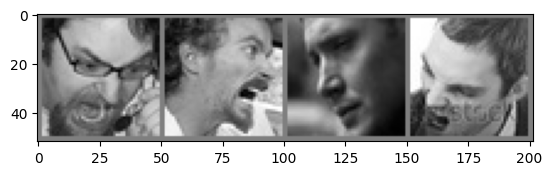

Predicted: ['angry', 'angry', 'sad', 'sad']
Actual: ['angry', 'angry', 'angry', 'angry']


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images[:4]))
print('Predicted:', [class_names[p] for p in preds[:4]])
print('Actual:', [class_names[l] for l in labels[:4]])


In [10]:
torch.save(model.state_dict(), "emotion_model.pth")